In [15]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [16]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 

In [17]:
train_data_dir = 'C:/FYP/train'
test_data_dir = 'C:/FYP/test1'

class_subset = sorted(os.listdir('C:/FYP/try'))[:10] # Using only the first 10 classes

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=123)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=123)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=123)

Found 4051 images belonging to 10 classes.
Found 711 images belonging to 10 classes.
Found 460 images belonging to 10 classes.


In [5]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [7]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# callbacks_list = [early_stop,tl_checkpoint_1]

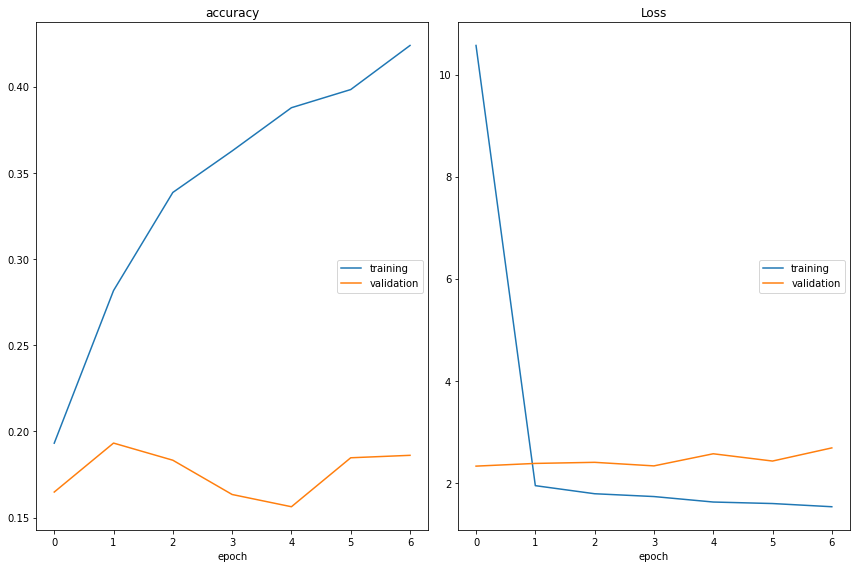

accuracy
	training         	 (min:    0.193, max:    0.424, cur:    0.424)
	validation       	 (min:    0.156, max:    0.193, cur:    0.186)
Loss
	training         	 (min:    1.532, max:   10.569, cur:    1.532)
	validation       	 (min:    2.327, max:    2.684, cur:    2.684)
63/63 [==============================] - 1463s 23s/step - loss: 1.5317 - accuracy: 0.4239 - val_loss: 2.6845 - val_accuracy: 0.1861
Epoch 8/50
61/63 [============================>.] - ETA: 9:24 - loss: 1.5136 - accuracy: 0.4276 

In [8]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [24]:
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

886/886 [==============================] - 34s 38ms/step


In [25]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 73.48%


In [27]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
test_labels=testgen.classes
model = load_model("tl_model_v1.weights.best.hdf5")
test_loss= model.evaluate(testgen)
prediction=model.predict(testgen)
prediction=np.argmax(prediction,axis=1)
print(classification_report(prediction,test_labels))
from sklearn import metrics
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(test_labels,prediction))

886/886 [==============================] - 31s 35ms/step
              precision    recall  f1-score   support

           0       0.57      0.84      0.68       298
           1       0.89      0.68      0.77       588

    accuracy                           0.73       886
   macro avg       0.73      0.76      0.73       886
weighted avg       0.79      0.73      0.74       886

[[250 187]
 [ 48 401]]


In [10]:
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

c:\Users\AT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=callbacks_list,
                                  verbose=1)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 2.8007 - accuracy: 0.1558
Epoch 1: val_loss did not improve from 2.19174
63/63 [==============================] - 79s 1s/step - loss: 2.8007 - accuracy: 0.1558 - val_loss: 2.4330 - val_accuracy: 0.1207
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 2.1864 - accuracy: 0.2097
Epoch 2: val_loss did not improve from 2.19174
63/63 [==============================] - 85s 1s/step - loss: 2.1864 - accuracy: 0.2097 - val_loss: 2.3436 - val_accuracy: 0.1662
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 2.1146 - accuracy: 0.2287
Epoch 3: val_loss did not improve from 2.19174
63/63 [==============================] - 88s 1s/step - loss: 2.1146 - accuracy: 0.2287 - val_loss: 2.3962 - val_accuracy: 0.1307
Epoch 4/50
63/63 [==============================] - ETA: 0s - loss: 2.0554 - accuracy: 0.2553
Epoch 4: val_loss did not improve from 2.19174
63/63 [==============================] - 89s 1s/s

In [12]:
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

460/460 [==============================] - 16s 33ms/step


In [13]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 10.87%
